# PRELIMINARY: Data exploration

## 1/ Dataframe preparation

On commence par explorer le sujet. Dans un premier temps, on regarde le documents csv fournit et on prépare les datas.

In [1]:
import numpy as np
import pandas as pd
import re
import os

In [2]:
path = "./data/annotations.csv"

In [3]:
def custom_split(s):
    '''
    Cette regex divise par des virgules, mais ignore celles à l'intérieur des parenthèses
    '''
    return re.split(r',\s*(?![^()]*\))', s)

data = []
with open(path, 'r') as f:
    headers = custom_split(f.readline().strip())
    for line in f:
        # Elimination des guillemets
        line = line.replace('"', '')
        # Séparation des valeurs avec la méthode custom_split précédente
        values = custom_split(line.strip())
        data.append(values)

# Conversion en DataFrame
df_raw = pd.DataFrame(data, columns=headers)

On enlève les colonnes inutiles pour la suite du problème.    
On fait le choix ici de ne pas prendre en compte l'annotation 'Breslow' qui n'a qu'une seule représentation (1ere ligne).    
On fait aussi le choix de se concentrer sur la representation type OpenCV.    
Cela pourra permettre d'améliorer les performances du modèle par la suite. A confirmer pour aller plus loin, mais il semble que ce soit une mesure de profondeur plutot qu'une zone à détecter, et donc cette étape pourrait être fait par la suite.

In [4]:
# Selection des colonnes d'interet
df = df_raw.iloc[:,:-3]
df = df.drop(['filename', 'Area'], axis=1)

# drop de la première ligne
df = df.drop(df.loc[df['Annotation_ID'] == '440864'].index)

In [5]:
# nb de classes totale dans ces annotations
df['Annotation_Term'].nunique()

5

Maintenant, on crée de nouvelles colonnes avec une mise en formes des coordonnées pour pouvoir par la suite tracer les shapes correctement.   
On fait un test sur trois niveaux de downsampling du WSI pour vérifier la cohérence des coordonnées à chaque fois.

In [6]:
def parse_(s):
    '''
    Function to extract coordinates properly
    '''
    points = re.findall(r'(\d+ \d+)', s)
    return [tuple(map(int, pt.split())) for pt in points]

# extraction des coordonnées (se sont les coordonnées pour la page 0)
df['parsed_opencv_coords'] = df['opencv_geometry'].apply(parse_)


def adjust_coordinates(coords_list, coeff):
    '''
    # function to adjust coordinates to the level of downsmapling choosen
    '''
    return [(int(x/coeff), int(y/coeff)) for (x, y) in coords_list]

# on ajuste les coordonnées sur 3 niveaux pour explorer
df['adjusted_coords_x8'] = df['parsed_opencv_coords'].apply(adjust_coordinates, coeff=8)
df['adjusted_coords_x16'] = df['parsed_opencv_coords'].apply(adjust_coordinates, coeff=16)
df['adjusted_coords_x32'] = df['parsed_opencv_coords'].apply(adjust_coordinates, coeff=32)

df.head(3)

,Annotation_ID,Annotation_Term,Perimeter,WKT_geometry,opencv_geometry,parsed_opencv_coords,adjusted_coords_x8,adjusted_coords_x16,adjusted_coords_x32
1,440801,Normal sub-cutaneous tissue,5.712296422763127,"LINESTRING (10640 56880, 10608 56816, 10608 56...","LINESTRING (10640 28112, 10608 28176, 10608 28...","[(10640, 28112), (10608, 28176), (10608, 28656...","[(1330, 3514), (1326, 3522), (1326, 3582), (13...","[(665, 1757), (663, 1761), (663, 1791), (661, ...","[(332, 878), (331, 880), (331, 895), (330, 896..."
2,440784,Normal dermis,12.489466314098886,"LINESTRING (3152 51760, 3152 51632, 3184 51536...","LINESTRING (3152 33232, 3152 33360, 3184 33456...","[(3152, 33232), (3152, 33360), (3184, 33456), ...","[(394, 4154), (394, 4170), (398, 4182), (402, ...","[(197, 2077), (197, 2085), (199, 2091), (201, ...","[(98, 1038), (98, 1042), (99, 1045), (100, 104..."
3,440761,Normal epidermis (with papillary dermis),12.361687098401404,"LINESTRING (2192 51376, 2288 51376, 2480 51568...","LINESTRING (2192 33616, 2288 33616, 2480 33424...","[(2192, 33616), (2288, 33616), (2480, 33424), ...","[(274, 4202), (286, 4202), (310, 4178), (334, ...","[(137, 2101), (143, 2101), (155, 2089), (167, ...","[(68, 1050), (71, 1050), (77, 1044), (83, 1044..."


***

## 2/ Image Exploration

On regarde maintenant de plus près l'image WSI fournie   
(partie de code fournie avec le sujet)

In [7]:
import matplotlib.pyplot as plt
import pyvips  # pour installer pyvips, il faut installer les librairie libvips (https://github.com/libvips/pyvips#non-conda-install)
import cv2

In [8]:
path_img = "./data/m9de8lfp.tif"

In [9]:
slide = pyvips.Image.new_from_file(path_img)
number_of_pages = slide.get("n-pages")
print(f"Number of pages: {number_of_pages}")

Number of pages: 10


In [10]:
# load the full-resolution image
slide = pyvips.Image.new_from_file(path_img, page=0)
print(slide.width, slide.height)

77824 84992


In [11]:
# load the 16x downsampled image from page 4 (2 ** 4 = 16)
slide = pyvips.Image.new_from_file(path_img, page=4)
print(slide.width, slide.height)

4864 5312


In [12]:
# read an image region in as a PIL Image
x, y = 100, 200
region_width = 500
region_height = 500
region = slide.crop(x, y, region_width, region_height)

In [13]:
# convert the PIL Image to a numpy array
array = np.ndarray(
    buffer=region.write_to_memory(),
    dtype=np.uint8,
    shape=(region.height, region.width, region.bands)
)
# red, green, blue channels
print(array.shape)

(500, 500, 3)


In [14]:
# also look into pyvips.Region.fetch for faster region read
region = pyvips.Region.new(slide).fetch(x, y, region_width, region_height)

bands = 3
array = np.ndarray(
    buffer=region,
    dtype=np.uint8,
    shape=(region_height, region_width, bands)
)
print(array.shape)

(500, 500, 3)


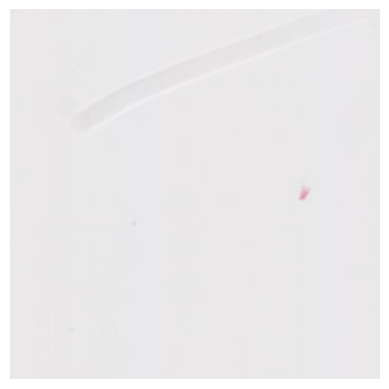

In [15]:
# Afficher l'image (croppé)
plt.imshow(array)
plt.axis('off')  # pour cacher les axes
plt.show()

***

# OBJECTIVE 1: tissue regions detection
## 1.1/ Méthode automatique

L'idée et d'obtenir une découpe automatique des zones de tissue, à partir d'une détection de forme puis d'un algo de k-mean clustering   
On obtient ensuite les dimensions de ces nouvelles images découpées pour rechercher les annotations correspondantes 
    
/!\ Cette partie d'automatisation n'est pas finalisée et un découpage manuelle pour la suite de l'exercice a été fait en partie 1.2  

In [16]:
from PIL import Image

In [17]:
def save_tissue_regions(wsi_path, output_folder, min_area=20000, page=5):
    '''
    Extract and save tissue regions from a Whole Slide Image (WSI). This function processes a given WSI, identifies regions with tissues based 
    on color intensity, and saves these regions as separate PNG images if their area exceeds a specified threshold.
    '''
    img = pyvips.Image.new_from_file(wsi_path, page=page)
    
    # Convertir l'image pyvips en array numpy
    np_img = np.ndarray(buffer=img.write_to_memory(),
                        dtype=np.uint8,
                        shape=[img.height, img.width, img.bands])
    
    # Convertir en niveaux de gris
    gray = cv2.cvtColor(np_img, cv2.COLOR_BGR2GRAY)
    
    # Seuillage pour détecter les tissus
    _, binary = cv2.threshold(gray, 220, 255, cv2.THRESH_BINARY_INV)
    
    # Trouver les contours
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    base_filename = os.path.basename(wsi_path).split('.')[0]
    
    # Enregistrer les régions de tissus
    for idx, contour in enumerate(contours):
        # Filtre basé sur une superficie minimale
        if cv2.contourArea(contour) < min_area:
            continue
        
        x, y, w, h = cv2.boundingRect(contour)
        cropped_tissue = np_img[y:y+h, x:x+w]
        output_path = os.path.join(output_folder, f"{base_filename}_{idx}.png")
        cv2.imwrite(output_path, cropped_tissue)

# Utilisation de la fonction save_tissue_regions
# path_img = "./data/m9de8lfp.tif"
# output_folder = './img'
# save_tissue_regions(path_img, output_folder)

## 1.2/ Méthode manuelle

Dans un premier temps, l'image (downsample 32, page 5) a été découpé manuellement en 4 parties nommées : filename_i.png    
- filename_1 sera associé à mask_c1 : zone en haut à gauche de l'image initiale    
- filename_2 sera associé à mask_c2 : zone en haut à droite de l'image initiale    
- filename_3 sera associé à mask_c3 : zone en bas à gauche de l'image initiale    
- filename_4 sera associé à mask_c4 : zone en bas à droite de l'image initiale   

In [18]:
# load the initial 32x downsampled image
slide = pyvips.Image.new_from_file(path_img, page=5)
print(f"Image initiale : \nlargeur : {slide.width}, hauteur : {slide.height}")

Image initiale : 
largeur : 2432, hauteur : 2656


In [19]:
def get_image_dimensions(directory):
    '''
    Calcul et retourne les dimensions de chacunes des images d'un dossier
    '''
    dimensions = {}
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        try:
            with Image.open(filepath) as img:
                width, height = img.size
                dimensions[filename] = (width, height)
        except Exception as e:
            print(f"Erreur lors de la lecture de {filename}: {e}")
    return dimensions 

print("Images découpées issues de l'image initiale :")
dimensions = get_image_dimensions('./img/img_c')
for img, dim in dimensions.items():
    print(f"{img}: {dim}")

Images découpées issues de l'image initiale :
filename_3.png: (786, 1179)
filename_2.png: (1733, 1249)
filename_1.png: (734, 1474)
filename_4.png: (1615, 1402)


***

# OBJECTIVE 2 : Mask creation

avant tout, on construit un dictionnaire {classes présentent dans les annotations : tuple RGB de couleur} qui nous servira pour la suite.

In [20]:
# création d'un dictionnaire de couleur des classes
unique_terms = df['Annotation_Term'].unique()

colors = {}
for term in unique_terms:
    colors[term] = tuple(map(int, np.random.randint(0, 256, 3)))  # Génère une couleur aléatoire pour chaque terme
    
colors

{'Normal sub-cutaneous tissue': (64, 199, 190),
 'Normal dermis': (188, 97, 32),
 'Normal epidermis (with papillary dermis)': (134, 19, 174),
 'Dermal component of melanoma': (20, 215, 192),
 'Intra-epidermal component of melanoma': (134, 220, 153)}

## 2.1/ Mask Exploration

Pour rappel : page1 = downsampling x2 ; page2 = x4 ; page3 = x8 ; page4 = x16 ; page5 = x32   
On commence par afficher l'image totale, puis l'image totale et tous les masques au dessus. 

2656 2432


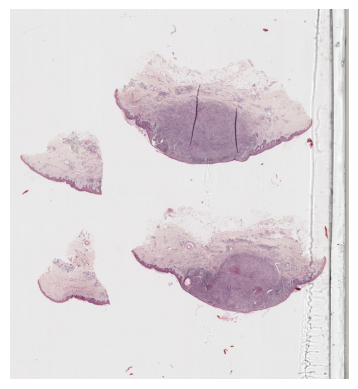

In [21]:
slide = pyvips.Image.new_from_file(path_img, page=5)

np_image = np.ndarray(buffer=slide.write_to_memory(),
                      dtype=np.uint8,
                      shape=[slide.height, slide.width, slide.bands])

print(slide.height, slide.width)

plt.imshow(np_image)
plt.axis('off') 
plt.show()

# export l'image totale pour vérifier le comportement des differentes couches de downsampling
# np_image_bgr = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)
# cv2.imwrite('./img/img_x32.png', np_image_bgr)

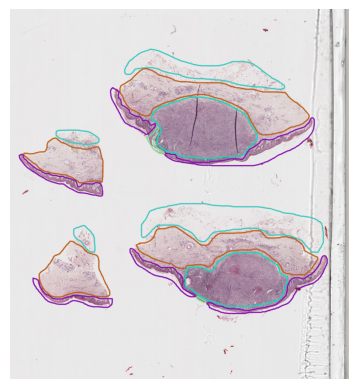

In [22]:
#affichage des masks dans une couleur suivant sa classe, puis par dessus l'image
for index, row in df.iterrows():
    coords = row['adjusted_coords_x32']
    class_name = row['Annotation_Term']
    color = colors.get(class_name, (255, 255, 255))  # Par défaut, utiliser le blanc si la classe n'est pas trouvée
    
    # Convertir les coordonnées en un numpy array et le remodeler
    pts = np.array(coords, np.int32)
    pts = pts.reshape((-1, 1, 2))

    cv2.polylines(np_image, [pts], isClosed=True, color=color, thickness=7)

plt.imshow(np_image)
plt.axis('off')
plt.show()

# exporter l'image pour vérifier le comportement image+masque des differentes couches de downsampling
# np_image_bgr = cv2.cvtColor(np_image, cv2.COLOR_RGB2BGR)
# cv2.imwrite('./img/img_x32_masks.png', np_image_bgr)

## 2.2/ Mask creation on img_c2

On se concentre maintenant sur une seule région : on choisit c2 (image en haut droite) car elle comprends toutes les classes à détecter.     
Les dimensions des 4 images découpées, par rapport aux dimensions de l'image initiale, permettent de retrouver les annotations de masque correspondantes.   
On génére ensuite les masks (c1, c2, c3 et c4) pour les 4 images filename_i.

In [23]:
#Pour rappel on a :
print(f"Image initiale (downsample_32) : ({slide.width}, {slide.height})")

for img, dim in dimensions.items():
    print(f"{img}: {dim}")

Image initiale (downsample_32) : (2432, 2656)
filename_3.png: (786, 1179)
filename_2.png: (1733, 1249)
filename_1.png: (734, 1474)
filename_4.png: (1615, 1402)


In [24]:
# Dimensions totales de l'image (en downsampling 32)
total_width = 2432
total_height = 2656

# Dimensions des images découpées avec les coordonnées ajustées (formatage OpenCV : origine en haut à gauche)
# utilisation de nombre 'en dur' mais à paramétrer pour une utilisation automatisée
image_dims = {
    'filename_1.png': (0, 0, 734, 1474),
    'filename_2.png': (total_width-1733, 0, total_width, 1249),
    'filename_3.png': (0, total_height-1179, 786, total_height),
    'filename_4.png': (total_width-1615, total_height-1402, total_width, total_height)
}

# fonction pour tester à quelle image appartient un point
def shape_belongs_to_image(points, dims):
    for img, (x1, y1, x2, y2) in dims.items():
        if all(x1 <= x <= x2 and y1 <= y <= y2 for x, y in points):
            return img
    return None

# On applique la fonction à chaque ligne du dataframe
df['image_matching'] = df['adjusted_coords_x32'].apply(lambda x: shape_belongs_to_image(x, image_dims))

# On afficher le résultat du matching dans le df
df[['adjusted_coords_x32', 'image_matching']]

,adjusted_coords_x32,image_matching
1,"[(332, 878), (331, 880), (331, 895), (330, 896...",filename_1.png
2,"[(98, 1038), (98, 1042), (99, 1045), (100, 104...",filename_1.png
3,"[(68, 1050), (71, 1050), (77, 1044), (83, 1044...",filename_1.png
4,"[(173, 1935), (181, 1935), (187, 1937), (193, ...",filename_3.png
5,"[(429, 1667), (443, 1667), (449, 1669), (453, ...",filename_3.png
6,"[(529, 1553), (517, 1557), (513, 1559), (507, ...",filename_3.png
7,"[(961, 1525), (977, 1503), (981, 1495), (983, ...",filename_4.png
8,"[(935, 1685), (925, 1685), (921, 1687), (915, ...",filename_4.png
9,"[(1263, 1905), (1263, 1883), (1265, 1877), (12...",filename_4.png
10,"[(1429, 2141), (1431, 2137), (1429, 2135), (14...",filename_4.png


In [25]:
#Creations des masks
values = ['1', '2', '3', '4']

for c in values:
    # On filtre le dataframe pour ne garder que les formes correspondant à l'image filename_i.png
    df_cx = df[df['image_matching'] == f'filename_{c}.png']

    # génére un mask vide
    combined_mask = np.zeros((slide.height, slide.width, 3), dtype=np.uint8)

    for index, row in df_cx.iterrows():
        # génére un nouveau mask vide (pour une annotation)
        mask = np.zeros((slide.height, slide.width, 3), dtype=np.uint8)

        # polygone rempli avec la couleur
        coords = row['adjusted_coords_x32']
        color = colors[row['Annotation_Term']]
        cv2.fillPoly(mask, [np.array(coords, dtype=np.int32)], color)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        # Sauvegarde le masque
        cv2.imwrite(f'./mask/mask_{index}.png', mask)

        # Ajout au masque 'combiné'
        combined_mask = cv2.add(combined_mask, mask)

        # Recadre le masque cumulé selon les dimensions de la sous-image
        x_min, y_min, x_max, y_max = image_dims[f'filename_{c}.png']
        cropped_combined_mask = combined_mask[y_min:y_max, x_min:x_max]

    # Sauvegarde le masque assemblé
    cv2.imwrite(f'./mask/mask_c/mask_c{c}.png', cropped_combined_mask)

***

# OBJECTIVE 3: U-Net Model

La suite de l'exercice (entrainement d'un model U-Net) sera fait sur le coin en haut à droite (filename_2 et mask_c2) qui contient tous les types de marquage

In [26]:
import random
import torch
import segmentation_models_pytorch as smp
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torch.utils.data import random_split

/home/thmsg/miniconda3/envs/test-diadeep/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.is_available())

True


In [28]:
colors

{'Normal sub-cutaneous tissue': (64, 199, 190),
 'Normal dermis': (188, 97, 32),
 'Normal epidermis (with papillary dermis)': (134, 19, 174),
 'Dermal component of melanoma': (20, 215, 192),
 'Intra-epidermal component of melanoma': (134, 220, 153)}

In [29]:
# #vérification matching couleur d'un mask et dans le dictionnaire
# mask_dir = './mask/mask_c/'

# for mask_path in os.listdir(mask_dir):
#     mask = Image.open(os.path.join(mask_dir, mask_path))
#     unique_colors = np.unique(np.array(mask).reshape(-1, 3), axis=0)
    
#     for color in unique_colors:
#         if tuple(color) not in colors.values():
#             print(f"Unknown color {color} in {mask_path}")

## 3.1/ Model

In [39]:
net = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=1,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=len(colors),            # model output channels (number of classes in your dataset)        
)

net.to(device);

## 3.2/ Data preparation & transformation

In [40]:
class WSIDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = [img for img in os.listdir(image_dir) if "filename" in img]
    
        # Obtenir la taille maximale
        self.max_width, self.max_height = get_max_size(image_dir)
    
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.images[idx])
        mask_path = os.path.join(self.mask_dir, self.images[idx].replace('filename_', 'mask_c'))
        
        image = Image.open(img_path).convert('L')
        mask = Image.open(mask_path)
        mask = rgb_to_mask(np.array(mask), colors)
        
        # Redimensionne à la taille maximale
        image = image.resize((self.max_width, self.max_height), Image.Resampling.LANCZOS)
        mask = mask.resize((self.max_width, self.max_height), Image.NEAREST)

        # transformations spatiales (data augmentation)
        image, mask = apply_transforms(image, mask)
        
        # padding
        padding = get_padding(image)
        image = transforms.Pad(padding)(image)
        mask = transforms.Pad(padding)(mask)
        
        # Convertir en tenseurs
        image = transforms.ToTensor()(image)
        mask = transforms.ToTensor()(mask) * 255
        mask = mask.to(torch.int64) 
        
        return image, mask



def get_max_size(image_dir):
    '''
    Renvoi la largeur et la hauteur des images d'un dossier
    '''
    max_width = 0
    max_height = 0
    for image_name in os.listdir(image_dir):
        with Image.open(os.path.join(image_dir, image_name)) as img:
            width, height = img.size
            max_width = max(max_width, width)
            max_height = max(max_height, height)
    return max_width, max_height
    
def rgb_to_mask(img, color_dict):
    """
    Convert an RGB image where different colors represent different classes into a 2D numpy array 
    where integers represent the classes.
    """
    mask = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
    for key, value in color_dict.items():
        mask[np.where((img == value).all(axis=-1))] = list(color_dict.keys()).index(key)  
    mask_pil = Image.fromarray(mask)
    return mask_pil

def apply_transforms(image, mask):
    '''
    Transformations spatiales
    '''
    if random.random() > 0.5:
        image = transforms.functional.hflip(image)
        mask = transforms.functional.hflip(mask) 
    if random.random() > 0.5:
        image = transforms.functional.vflip(image)
        mask = transforms.functional.vflip(mask)
    angle = random.uniform(-40, 40)
    image = transforms.functional.rotate(image, angle)
    mask = transforms.functional.rotate(mask, angle)
    return image, mask
    
def get_padding(image):
    '''
    Calcule le montant nécessaire pour le padding
    '''
    pad_height = (32 - (image.height % 32)) % 32
    pad_width = (32 - (image.width % 32)) % 32
    return (0, 0, pad_width, pad_height)

In [41]:
# Crée un ensemble de données complet
full_dataset = WSIDataset(image_dir="./img/img_c/", mask_dir="./mask/mask_c/")

# Divise le jeu de données en ensembles d'entraînement (75% = 3 images) et de validation (25% = 1 image)
train_size = int(len(full_dataset)*.75)
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Crée des chargeurs de données train et validation
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [42]:
# # Vérification
# print(len(train_loader))
# image, mask = next(iter(train_loader))
# print(image.shape)
# print(mask.shape)
# print(np.unique(mask))

# print(len(val_loader))
# image, mask = next(iter(val_loader))
# print(image.shape)
# print(mask.shape)
# print(np.unique(mask))

## 3.3/ Training

In [43]:
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for images, masks in loader:
        images, masks = images.to(device), masks.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        masks = masks.squeeze(1)
        outputs = outputs[:, :, :masks.shape[1], :masks.shape[2]]
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


def dice_coefficient(mask_true, mask_pred):
    mask_true_binary = mask_true > 0
    mask_pred_binary = mask_pred > 0
    intersection = np.logical_and(mask_true_binary, mask_pred_binary)
    return (2. * np.sum(intersection)) / (np.sum(mask_true_binary) + np.sum(mask_pred_binary))


def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0.0
    total_dice = 0.0
    with torch.no_grad():
        for images, masks in loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            masks = masks.squeeze(1)
            outputs = outputs[:, :, :masks.shape[1], :masks.shape[2]]
            loss = criterion(outputs, masks)
            total_loss += loss.item()
            # Calculate dice coefficient for the batch
            dice = dice_coefficient(masks.cpu().numpy(), outputs.argmax(1).cpu().numpy())
            total_dice += dice
    return total_loss / len(loader), total_dice / len(loader)

# Configuration
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
num_epochs = 50
train_losses = []
val_losses = []
dice_scores = []

# Entrainement et validation
for epoch in range(num_epochs):
    train_loss = train_one_epoch(net, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)
    val_loss, val_dice  = validate(net, val_loader, criterion, device)
    val_losses.append(val_loss)
    dice_scores.append(val_dice)
    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}, Dice coeff:  {val_dice}")

Epoch 1/50, Training Loss: 1.6091548601786296, Validation Loss: 3.831294298171997, Dice coeff:  0.2356706370559565
Epoch 2/50, Training Loss: 1.1162806749343872, Validation Loss: 0.9884455800056458, Dice coeff:  0.16902610222511705
Epoch 3/50, Training Loss: 0.8286910255750021, Validation Loss: 0.5927622318267822, Dice coeff:  0.098332337118948
Epoch 4/50, Training Loss: 0.6273859937985738, Validation Loss: 2.0609374046325684, Dice coeff:  0.0
Epoch 5/50, Training Loss: 0.524190753698349, Validation Loss: 0.5501405000686646, Dice coeff:  0.009641546847298177
Epoch 6/50, Training Loss: 0.6128911375999451, Validation Loss: 0.42262640595436096, Dice coeff:  0.6418955517445533
Epoch 7/50, Training Loss: 0.37848936518033344, Validation Loss: 0.4409949481487274, Dice coeff:  0.8574447846463875
Epoch 8/50, Training Loss: 0.3379007577896118, Validation Loss: 0.295878142118454, Dice coeff:  0.8523249317520462
Epoch 9/50, Training Loss: 0.2941802144050598, Validation Loss: 0.36198753118515015, D

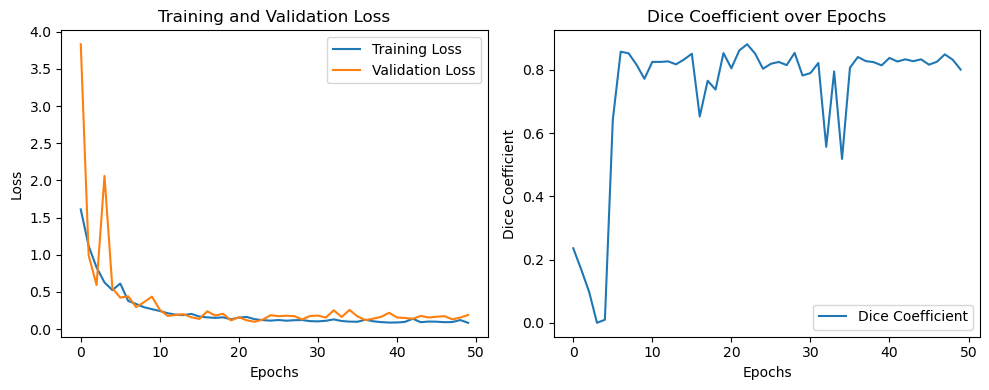

In [44]:
# Plot training and validation loss
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
# Plot Dice coefficient
plt.subplot(1, 2, 2)
plt.plot(dice_scores, label="Dice Coefficient")
plt.xlabel("Epochs")
plt.ylabel("Dice Coefficient")
plt.title("Dice Coefficient over Epochs")
plt.legend()
plt.tight_layout()
plt.show()

## 3.4/ Validation

images shape: torch.Size([1, 1, 1504, 1760])
Outputs shape: torch.Size([1, 5, 1504, 1760])
Masks shape: torch.Size([1, 1, 1504, 1760])
Unique values in mask: tensor([0, 1, 2], device='cuda:0')
Unique values in output: tensor([-11.1877, -11.1791, -11.1770,  ...,   6.1413,   6.1455,   6.1507],
       device='cuda:0')
Unique values in predicted_masks: [0 1 2]


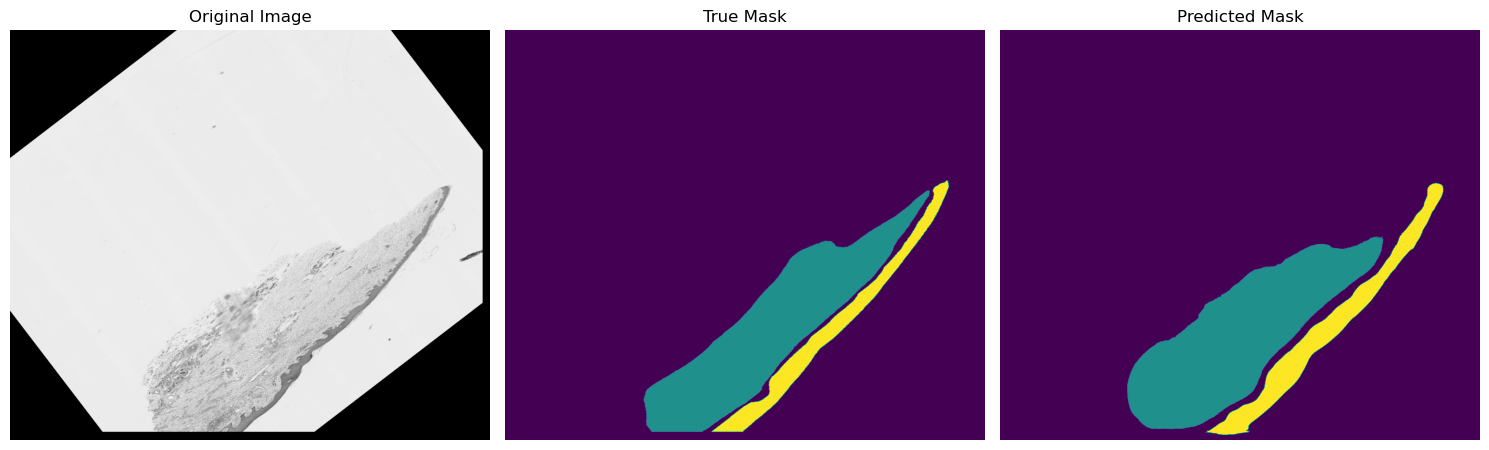

In [45]:
# On choisi une image de l'ensemble de validation
images, masks = next(iter(val_loader))
images, masks = images.to(device), masks.to(device)

# Inférence du modèle et Masque de prédiction
net.eval()
with torch.no_grad():
    outputs = net(images)
outputs = outputs[:, :, :masks.shape[2], :masks.shape[3]]
predicted_masks = torch.argmax(outputs, dim=1).squeeze().cpu().numpy()

# Vérifications
print("images shape:", images.shape)
print("Outputs shape:", outputs.shape)
print("Masks shape:", masks.shape)
print("Unique values in mask:", torch.unique(masks))
print("Unique values in output:", torch.unique(outputs))
print("Unique values in predicted_masks:", np.unique(predicted_masks))

# visualisation
image_np = images.cpu().squeeze().numpy()
true_mask_np = masks.cpu().squeeze().numpy()

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(image_np, cmap='gray')
ax[0].set_title("Original Image")
ax[1].imshow(true_mask_np)
ax[1].set_title("True Mask")
ax[2].imshow(predicted_masks)
ax[2].set_title("Predicted Mask")
for a in ax:
    a.axis('off')
plt.tight_layout()
plt.show()

## 3.5/ Model performance 

On commence par une étude de performance générale en regardant la métrique Accuracy et Dice.    
Ces indicateurs sont peu précis car ne prends pas en compte les differentes classes. De plus l'accuracy peut être trompeuse: si le background est prédominant, cela conduit à augmenter la valeur de l'accuracy sans rendre compte de la réalité de la performance de la prédiction.    
Ensuite, on calcul les differentes métriques : accuracy, precision, recall, specificity et Dice par classe.   

In [46]:
from sklearn.metrics import confusion_matrix

In [47]:
# Confusion Matrix, GLobal Accuracy and Dice
all_true_masks = true_mask_np.flatten()
all_pred_masks = predicted_masks.flatten()
cm = confusion_matrix(all_true_masks, all_pred_masks)

correct_predictions = np.sum(all_true_masks == all_pred_masks)
total_predictions = all_true_masks.size
accuracy = correct_predictions / total_predictions
print(f"Global Accuracy: {accuracy:.3f}")

dice_global = dice_coefficient(all_true_masks, all_pred_masks)
print(f"Global Dice Coefficient: {dice_global:.3f}\n")


def calculate_metrics(tp, fp, fn, tn):
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) != 0 else 0
    recall = tp / (tp + fn) if (tp + fn) != 0 else 0
    specificity = tn / (tn + fp) if (tn + fp) != 0 else 0
    return accuracy, precision, recall, specificity


# Metrics for each class
num_classes = cm.shape[0]
for class_idx in range(num_classes):
    tp = cm[class_idx, class_idx]
    fp = cm[:, class_idx].sum() - tp
    fn = cm[class_idx, :].sum() - tp
    tn = cm.sum() - (fp + fn + tp)
    
    accuracy, precision, recall, specificity = calculate_metrics(tp, fp, fn, tn)
    
    print(f"Classe {class_idx}:")
    print("-" * 30)
    print(f"Accuracy: {accuracy:.3f}")
    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"Specificity: {specificity:.3f}")
    print(f"Dice: {dice_coefficient(all_true_masks == class_idx, all_pred_masks == class_idx):.3f}")
    print("-" * 30)

Global Accuracy: 0.953
Global Dice Coefficient: 0.810

Classe 0:
------------------------------
Accuracy: 0.953
Precision: 0.983
Recall: 0.963
Specificity: 0.870
Dice: 0.973
------------------------------
Classe 1:
------------------------------
Accuracy: 0.960
Precision: 0.759
Recall: 0.844
Specificity: 0.972
Dice: 0.799
------------------------------
Classe 2:
------------------------------
Accuracy: 0.992
Precision: 0.759
Recall: 0.973
Specificity: 0.993
Dice: 0.853
------------------------------


***

# Nexts steps

Voici quelques pistes d'améliorations pour approfondir cet exercice.

- Il faudrait regarder plus en détail la partie 1.1 sur la détection automatique des zones de tissues :
    - Idéalement, il faudrait que la détection se fasse seule, par exemple en appliquant un seuillage et une méthode de k-mean clustering. 
    - Cela permettrait le découpage automatique des images en sous images et donc un traitement simplifié pour traiter de nouvelles images en grande quantité   
- faire une recherche d'hyperparamètres (GridSearch, Bayesian Search, ...)
- Améliorer l'étude de performance (implémenter d'autres indicateurs, revérifier la pertinence de la démarche, ...)
- Convertir le fichier notebook en scripts .py en vu d'une utilisation réelle
    